In [1]:
import cellgrid

import numpy as np

import scipy

from MDAnalysis.lib.distances import distance_array

from collections import defaultdict

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In distance calculations, one particular use case is to find all the pair contacts within a certain distance. It is used to characterize how many particles are in contact with each other. Cell-lists are one type of data strucutres particularly useful for dynamic datapoints as the time for construction usually scales with O(N) as opposed to O(NlogN) in KDtree strcutures.  

This notebook primarily deals with optimization of cell-list structure as implemented in Cellgrid module. Typically, the domain is divided into grids and points are binned into these grids. At present, the search radius is used as the grid size, which can be optimized based on the typical number of distance calculations per cell. With only cell-list structure in place, it is beneficial to use grid spacing atleast equal to the search radius as all the points within the search radius from a point will definitely lie in the neighbouring cells of the particle.

In this notebook, grid sizes larger than the search radius are explored with varying density of particles. It is hypothesized that if grids are created such that every cell undergoes optimum number of distance calculations at the cost of lower build time, the performance of cell-list data structures for dynamic data points can be improved. 

In [3]:
def CGsearch(box, points,  cellsize, searchradius = None):
    """
    box - box dimensions
    points -  Coordinates
    cellsize - Grid Size
    searchradius - Contact distance
    
    """
    if not searchradius:
        searchradius = cellsize
    box = _check_box(box)
    indx, dist = cellgrid.capped_self_distance_array(points, cellsize,box = box)
    mask = np.where(dist<searchradius)
    return indx[mask],dist[mask]

In [4]:
def timer(box, points, cellsize, searchradius):
    t = %timeit -o -q CGsearch(box, points, cellsize, searchradius)
    return t.average

In [5]:
def _check_box(box):
        return box[:3] if box.shape == (6,) else box
    
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*_check_box(box)).astype(np.float32)

In [6]:
def BFsearch(box, points, searchradius):
    """
    Calculates all the pairwise distances
    """
    distance = distance_array(points,points)
    distance[np.tril_indices(distance.shape[0])] += (1.1*searchradius)
    mask = np.where((distance < searchradius))
    indx = np.column_stack((mask[0],mask[1]))
    return indx,distance[mask]

Initialize
-----------

In [7]:
box = np.array([100, 100, 100, 90, 90, 90],dtype=np.float32)
Npoints = 100

In [8]:
points = get_coords(box,Npoints)
searchradius = 4.0

Testing
-------

In [9]:
#Brute Force
bf = BFsearch(box,points,searchradius)
#CellGrid Selection
cg = CGsearch(box,points,searchradius)

In [10]:
np.testing.assert_equal(np.unique(bf[0]),np.unique(cg[0]))

The parameters to change are the number of points, search radius and cellsize. For a given number of points and search radius, we change the cellsize and plot the number of points per cell vs time taken for the query. 

In [17]:
box = np.array([100, 100, 100, 90, 90, 90],dtype=np.float32)
searchradius = np.linspace(4, 9, num = 6)
Npoints = np.logspace(2, 4.4, num = 10, dtype = np.int)

In [18]:
time = defaultdict(list)
cellsizes = defaultdict(list)
for n in Npoints:
    points = get_coords(box,n)
    for radius in searchradius:
        for cs in np.linspace(radius, radius * 3, num = 10):
            time[str(n)+'.'+str(radius)].append(timer(box, points, cs, radius))
            cellsizes[str(n)+'.'+str(radius)].append(cs)

Visualization
-------------

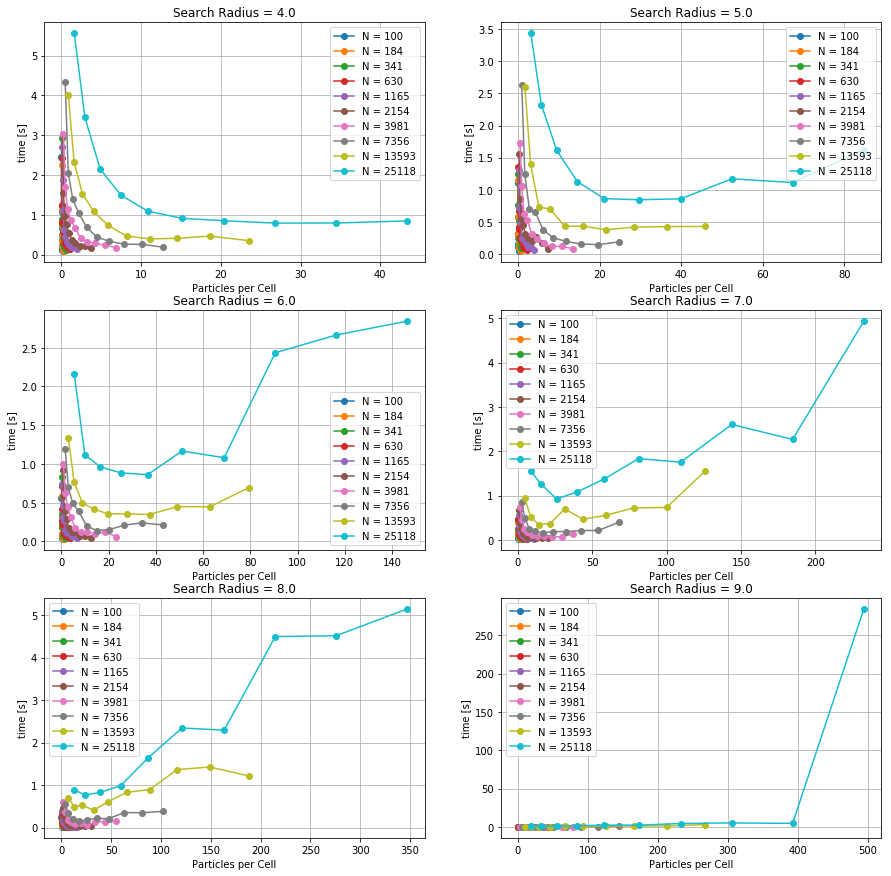

In [20]:
fig, axes = plt.subplots(nrows= len(searchradius)//2, ncols=2, figsize=(15,15))
for index,val in enumerate(searchradius):
    i,j = index // 2, index % 2
    for n in Npoints:
        p_percell,t_percell = [],[]
        query_str = '{}.{}'.format(str(n),str(val))
        for cs,t in zip(cellsizes[query_str], time[query_str]):
            ncells = box[0]/cs
            p_percell.append(n/(ncells **3))
            t_percell.append(t)
        axes[i,j].plot(p_percell, t_percell, 'o-', label='N = {}'.format(str(n)))
        axes[i,j].set(xlabel='Particles per Cell', ylabel='time [s]', title='Search Radius = {}'.format(val))
        axes[i,j].legend()
        axes[i,j].grid(True)

For all the particles, it is observed that particles per cell definitely impacts the time. From visual examination, a particle density of 30 particles per cell is a good approximation to reduce the overall time. Lets check the time difference for one instance to get an idea of time reduction. 

For N = 25k particles, and search radius = 6 units, time to evaluate contacts using current algorithm in Cellgrid can be found as:
$$ Ncells = \frac{100}{6} \approx 16 $$

$$ Particles \space per \space cell \approx \frac{25000}{16^3} \approx 6 $$

In [21]:
#CellGrid Current implementation
N = 25118
radius = 6.0
"{} sec".format(time[str(N)+'.'+str(radius)][0])

'2.1614822857141656 sec'

In [22]:
# Optimized in this case for Particles per cell approximately 30
"Time = {} sec, CellSize = {}".format(time[str(N)+'.'+str(radius)][4],cellsizes[str(N)+'.'+str(radius)][5])

'Time = 0.8625321428569025 sec, CellSize = 12.666666666666666'

Approximately 60% time can be reduced using optimized cellsize. For implementation in cellgrid, a seperate function can be added which calculates the cellsize correspoding to 30 particles per cell assuming uniform distribution for a given search radius. As the cell size should be greater than the search radius, another condition depending on the max(searchradius, calculated cellsize). With increase in number of particles, the number of cell would also increase and after a certain point, though the limit will be approached for higher number of particles. This is particularly advantageous for smaller cutoff distances, while for higher contact distances approach the timing achieved in current implementation.

A typical calculation can show the same. For these parameters:
* Box Size = 100
* Search Radius = 10
Number of cells when search radius is the cellsize :
$$ (\frac{100}{10})^3  = 1000 = \frac{N}{30}$$
$$ N = 30000 $$

However, for small cutoff radius i.e. 3 units,  
$$ N = \frac{3 \times 10^7}{r^3}  \approx 10^6 $$
